In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Data Preprocessing

### **Normalization**: The pixel values are scaled to the range [0, 1] for better training. Normalization helps in speeding up the convergence during training.

### **Reshape**: The images are reshaped to include a channel dimension (for grayscale images), making it compatible with the neural network input.

In [2]:
# Load MNIST dataset
(X_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5  # Normalize to [-1, 1]
X_train = np.expand_dims(X_train, axis=-1)

11490434/11490434 [==============================] - 0s 0us/step


# Build the Generator Model

### **Dense Layers:** The generator takes a random noise vector of size 100 as input and generates a 28x28 image. The first layer transforms the noise into a larger representation.

### **Activation Functions:** ReLU (Rectified Linear Unit) is used for the hidden layer, and sigmoid is used for the output layer to ensure pixel values are in the [0, 1] range.

In [3]:
# Generator model
def build_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(256, input_dim=100))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(28 * 28 * 1, activation='tanh'))
    model.add(layers.Reshape((28, 28, 1)))
    return model

generator = build_generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               25856     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                       

# Build the Discriminator Model

### **Flatten Layer:** The discriminator processes images by flattening them into a 1D vector before feeding them into fully connected layers.

### **Output Layer:** The output is a single value between 0 and 1, representing the probability that the input image is real.

In [4]:
# Discriminator model
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Flatten(input_shape=(28, 28, 1)))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               401920    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 257       
                                                                 
Total params: 533505 (2.04 MB)
Trainable params: 53350

# Compile the Models & Train the Model

### **Loss Function:** Binary cross-entropy is used because it is a binary classification problem (real vs. fake).

### **Optimizer:** Adam optimizer is chosen for its efficiency in training deep learning models.

### **Epochs:** The GAN is trained for a set number of epochs, with each epoch consisting of generating images and training the models.

### **Noise Generation:** Random noise is generated for the generator to create fake images.

In [5]:
# Compile GAN
def build_gan(generator, discriminator):
    discriminator.compile(optimizer=tf.keras.optimizers.Adam(0.0002), loss='binary_crossentropy', metrics=['accuracy'])
    discriminator.trainable = False
    gan_input = layers.Input(shape=(100,))
    generated_img = generator(gan_input)
    gan_output = discriminator(generated_img)
    gan = tf.keras.Model(gan_input, gan_output)
    gan.compile(optimizer=tf.keras.optimizers.RMSprop(0.0002), loss='binary_crossentropy')
    return gan

# Build models
generator = build_generator()
discriminator = build_discriminator()
gan = build_gan(generator, discriminator)

# Training function
def train(epochs, batch_size=128, save_interval=200):
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_imgs = X_train[idx]

        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(real_imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        g_loss = gan.train_on_batch(noise, real)
        print(f"Epoch {epoch + 1}/{epochs}")

        if epoch % save_interval == 0:
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}]")
            save_imgs(epoch)

# Image Generation and Visualization

2/2 [==============================] - 0s 6ms/step
Epoch 1/10001
0 [D loss: 0.8339674174785614, acc.: 37.5%] [G loss: 0.7130095362663269]
1/1 [==============================] - 0s 158ms/step


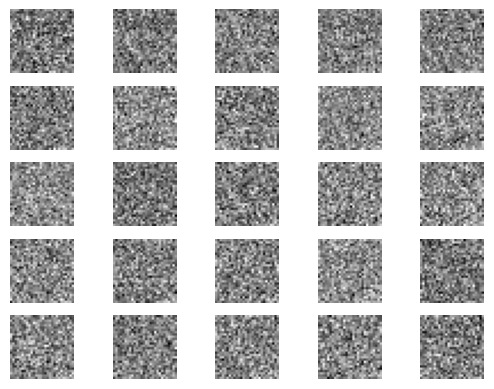

2/2 [==============================] - 0s 5ms/step
Epoch 2/10001
2/2 [==============================] - 0s 5ms/step
Epoch 3/10001
2/2 [==============================] - 0s 5ms/step
Epoch 4/10001
2/2 [==============================] - 0s 5ms/step
Epoch 5/10001
2/2 [==============================] - 0s 5ms/step
Epoch 6/10001
2/2 [==============================] - 0s 5ms/step
Epoch 7/10001
2/2 [==============================] - 0s 5ms/step
Epoch 8/10001
2/2 [==============================] - 0s 4ms/step
Epoch 9/10001
2/2 [==============================] - 0s 5ms/step
Epoch 10/10001
2/2 [==============================] - 0s 6ms/step
Epoch 11/10001
2/2 [==============================] - 0s 5ms/step
Epoch 12/10001
2/2 [==============================] - 0s 5ms/step
Epoch 13/10001
2/2 [==============================] - 0s 5ms/step
Epoch 14/10001
2/2 [==============================] - 0s 5ms/step
Epoch 15/10001
2/2 [==============================] - 0s 5ms/step
Epoch 16/10001
2/2 [=============

2/2 [==============================] - 0s 5ms/step
Epoch 1002/10001
2/2 [==============================] - 0s 5ms/step
Epoch 1003/10001
2/2 [==============================] - 0s 5ms/step
Epoch 1004/10001
2/2 [==============================] - 0s 5ms/step
Epoch 1005/10001
2/2 [==============================] - 0s 5ms/step
Epoch 1006/10001
2/2 [==============================] - 0s 5ms/step
Epoch 1007/10001
2/2 [==============================] - 0s 5ms/step
Epoch 1008/10001
2/2 [==============================] - 0s 5ms/step
Epoch 1009/10001
2/2 [==============================] - 0s 5ms/step
Epoch 1010/10001
2/2 [==============================] - 0s 5ms/step
Epoch 1011/10001
2/2 [==============================] - 0s 5ms/step
Epoch 1012/10001
2/2 [==============================] - 0s 5ms/step
Epoch 1013/10001
2/2 [==============================] - 0s 5ms/step
Epoch 1014/10001
2/2 [==============================] - 0s 5ms/step
Epoch 1015/10001
2/2 [==============================] - 0s 5ms/st

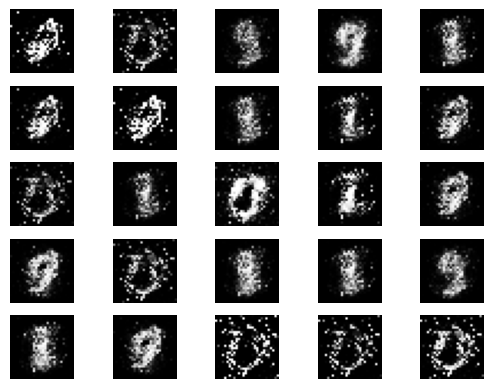

2/2 [==============================] - 0s 5ms/step
Epoch 2002/10001
2/2 [==============================] - 0s 5ms/step
Epoch 2003/10001
2/2 [==============================] - 0s 5ms/step
Epoch 2004/10001
2/2 [==============================] - 0s 4ms/step
Epoch 2005/10001
2/2 [==============================] - 0s 5ms/step
Epoch 2006/10001
2/2 [==============================] - 0s 5ms/step
Epoch 2007/10001
2/2 [==============================] - 0s 5ms/step
Epoch 2008/10001
2/2 [==============================] - 0s 5ms/step
Epoch 2009/10001
2/2 [==============================] - 0s 5ms/step
Epoch 2010/10001
2/2 [==============================] - 0s 5ms/step
Epoch 2011/10001
2/2 [==============================] - 0s 5ms/step
Epoch 2012/10001
2/2 [==============================] - 0s 5ms/step
Epoch 2013/10001
2/2 [==============================] - 0s 5ms/step
Epoch 2014/10001
2/2 [==============================] - 0s 5ms/step
Epoch 2015/10001
2/2 [==============================] - 0s 5ms/st

2/2 [==============================] - 0s 5ms/step
Epoch 3002/10001
2/2 [==============================] - 0s 5ms/step
Epoch 3003/10001
2/2 [==============================] - 0s 5ms/step
Epoch 3004/10001
2/2 [==============================] - 0s 5ms/step
Epoch 3005/10001
2/2 [==============================] - 0s 5ms/step
Epoch 3006/10001
2/2 [==============================] - 0s 5ms/step
Epoch 3007/10001
2/2 [==============================] - 0s 5ms/step
Epoch 3008/10001
2/2 [==============================] - 0s 5ms/step
Epoch 3009/10001
2/2 [==============================] - 0s 5ms/step
Epoch 3010/10001
2/2 [==============================] - 0s 6ms/step
Epoch 3011/10001
2/2 [==============================] - 0s 5ms/step
Epoch 3012/10001
2/2 [==============================] - 0s 5ms/step
Epoch 3013/10001
2/2 [==============================] - 0s 5ms/step
Epoch 3014/10001
2/2 [==============================] - 0s 5ms/step
Epoch 3015/10001
2/2 [==============================] - 0s 4ms/st

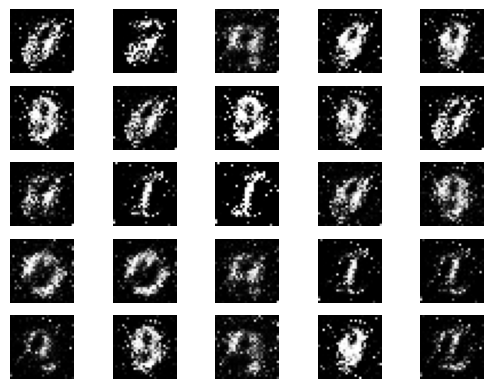

2/2 [==============================] - 0s 5ms/step
Epoch 4002/10001
2/2 [==============================] - 0s 4ms/step
Epoch 4003/10001
2/2 [==============================] - 0s 5ms/step
Epoch 4004/10001
2/2 [==============================] - 0s 5ms/step
Epoch 4005/10001
2/2 [==============================] - 0s 5ms/step
Epoch 4006/10001
2/2 [==============================] - 0s 4ms/step
Epoch 4007/10001
2/2 [==============================] - 0s 5ms/step
Epoch 4008/10001
2/2 [==============================] - 0s 5ms/step
Epoch 4009/10001
2/2 [==============================] - 0s 5ms/step
Epoch 4010/10001
2/2 [==============================] - 0s 5ms/step
Epoch 4011/10001
2/2 [==============================] - 0s 5ms/step
Epoch 4012/10001
2/2 [==============================] - 0s 4ms/step
Epoch 4013/10001
2/2 [==============================] - 0s 5ms/step
Epoch 4014/10001
2/2 [==============================] - 0s 4ms/step
Epoch 4015/10001
2/2 [==============================] - 0s 5ms/st

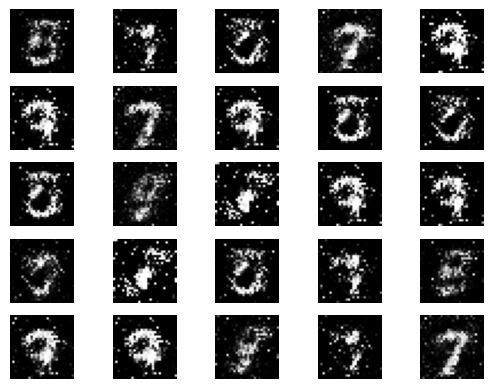

2/2 [==============================] - 0s 5ms/step
Epoch 5002/10001
2/2 [==============================] - 0s 5ms/step
Epoch 5003/10001
2/2 [==============================] - 0s 5ms/step
Epoch 5004/10001
2/2 [==============================] - 0s 5ms/step
Epoch 5005/10001
2/2 [==============================] - 0s 5ms/step
Epoch 5006/10001
2/2 [==============================] - 0s 5ms/step
Epoch 5007/10001
2/2 [==============================] - 0s 5ms/step
Epoch 5008/10001
2/2 [==============================] - 0s 5ms/step
Epoch 5009/10001
2/2 [==============================] - 0s 5ms/step
Epoch 5010/10001
2/2 [==============================] - 0s 5ms/step
Epoch 5011/10001
2/2 [==============================] - 0s 5ms/step
Epoch 5012/10001
2/2 [==============================] - 0s 5ms/step
Epoch 5013/10001
2/2 [==============================] - 0s 4ms/step
Epoch 5014/10001
2/2 [==============================] - 0s 5ms/step
Epoch 5015/10001
2/2 [==============================] - 0s 5ms/st

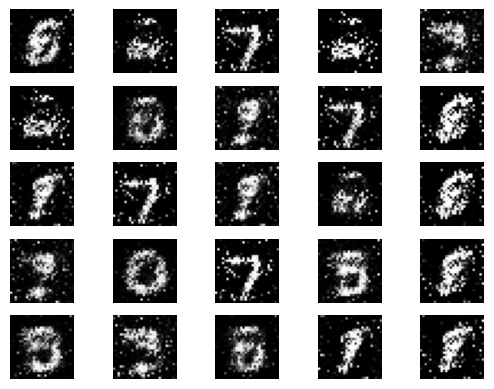

2/2 [==============================] - 0s 5ms/step
Epoch 6002/10001
2/2 [==============================] - 0s 5ms/step
Epoch 6003/10001
2/2 [==============================] - 0s 5ms/step
Epoch 6004/10001
2/2 [==============================] - 0s 4ms/step
Epoch 6005/10001
2/2 [==============================] - 0s 4ms/step
Epoch 6006/10001
2/2 [==============================] - 0s 5ms/step
Epoch 6007/10001
2/2 [==============================] - 0s 5ms/step
Epoch 6008/10001
2/2 [==============================] - 0s 5ms/step
Epoch 6009/10001
2/2 [==============================] - 0s 4ms/step
Epoch 6010/10001
2/2 [==============================] - 0s 5ms/step
Epoch 6011/10001
2/2 [==============================] - 0s 4ms/step
Epoch 6012/10001
2/2 [==============================] - 0s 5ms/step
Epoch 6013/10001
2/2 [==============================] - 0s 5ms/step
Epoch 6014/10001
2/2 [==============================] - 0s 5ms/step
Epoch 6015/10001
2/2 [==============================] - 0s 5ms/st

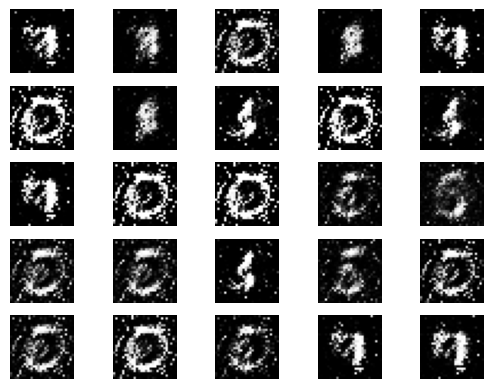

2/2 [==============================] - 0s 5ms/step
Epoch 7002/10001
2/2 [==============================] - 0s 4ms/step
Epoch 7003/10001
2/2 [==============================] - 0s 5ms/step
Epoch 7004/10001
2/2 [==============================] - 0s 5ms/step
Epoch 7005/10001
2/2 [==============================] - 0s 5ms/step
Epoch 7006/10001
2/2 [==============================] - 0s 5ms/step
Epoch 7007/10001
2/2 [==============================] - 0s 5ms/step
Epoch 7008/10001
2/2 [==============================] - 0s 5ms/step
Epoch 7009/10001
2/2 [==============================] - 0s 5ms/step
Epoch 7010/10001
2/2 [==============================] - 0s 5ms/step
Epoch 7011/10001
2/2 [==============================] - 0s 5ms/step
Epoch 7012/10001
2/2 [==============================] - 0s 4ms/step
Epoch 7013/10001
2/2 [==============================] - 0s 5ms/step
Epoch 7014/10001
2/2 [==============================] - 0s 5ms/step
Epoch 7015/10001
2/2 [==============================] - 0s 5ms/st

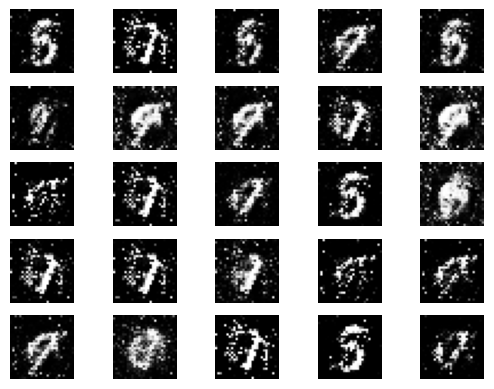

2/2 [==============================] - 0s 5ms/step
Epoch 8002/10001
2/2 [==============================] - 0s 5ms/step
Epoch 8003/10001
2/2 [==============================] - 0s 4ms/step
Epoch 8004/10001
2/2 [==============================] - 0s 5ms/step
Epoch 8005/10001
2/2 [==============================] - 0s 5ms/step
Epoch 8006/10001
2/2 [==============================] - 0s 5ms/step
Epoch 8007/10001
2/2 [==============================] - 0s 5ms/step
Epoch 8008/10001
2/2 [==============================] - 0s 5ms/step
Epoch 8009/10001
2/2 [==============================] - 0s 5ms/step
Epoch 8010/10001
2/2 [==============================] - 0s 5ms/step
Epoch 8011/10001
2/2 [==============================] - 0s 5ms/step
Epoch 8012/10001
2/2 [==============================] - 0s 5ms/step
Epoch 8013/10001
2/2 [==============================] - 0s 5ms/step
Epoch 8014/10001
2/2 [==============================] - 0s 4ms/step
Epoch 8015/10001
2/2 [==============================] - 0s 5ms/st

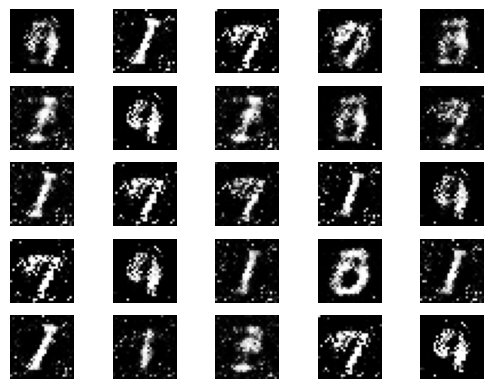

2/2 [==============================] - 0s 5ms/step
Epoch 9002/10001
2/2 [==============================] - 0s 5ms/step
Epoch 9003/10001
2/2 [==============================] - 0s 5ms/step
Epoch 9004/10001
2/2 [==============================] - 0s 5ms/step
Epoch 9005/10001
2/2 [==============================] - 0s 5ms/step
Epoch 9006/10001
2/2 [==============================] - 0s 5ms/step
Epoch 9007/10001
2/2 [==============================] - 0s 5ms/step
Epoch 9008/10001
2/2 [==============================] - 0s 5ms/step
Epoch 9009/10001
2/2 [==============================] - 0s 5ms/step
Epoch 9010/10001
2/2 [==============================] - 0s 5ms/step
Epoch 9011/10001
2/2 [==============================] - 0s 5ms/step
Epoch 9012/10001
2/2 [==============================] - 0s 5ms/step
Epoch 9013/10001
2/2 [==============================] - 0s 5ms/step
Epoch 9014/10001
2/2 [==============================] - 0s 5ms/step
Epoch 9015/10001
2/2 [==============================] - 0s 5ms/st

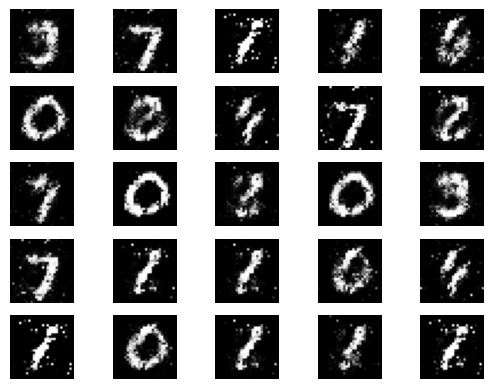

In [6]:
import os

# Function to save generated images
def save_imgs(epoch):
    noise = np.random.normal(0, 1, (25, 100))
    gen_imgs = generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5  # Rescale to [0, 1]

    # Create directory if it doesn't exist
    if not os.path.exists('generated_images-batch-64'):
        os.makedirs('generated_images-batch-64')

    fig, axs = plt.subplots(5, 5)
    cnt = 0
    for i in range(5):
        for j in range(5):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

    # Display the images
    plt.show()

    # Save the figure to a file
    fig.savefig(f"generated_images-batch-64/gan_image_epoch_{epoch}.png")
    plt.close()

# Train the GAN
train(epochs=10001, batch_size=64, save_interval=1000)

In [7]:
import shutil
import os
from google.colab import files

# Specify your directory name
directory_name = 'generated_images-batch-64'

# Check if the directory exists
if os.path.exists(directory_name):
    # Create a zip file of the directory
    shutil.make_archive(directory_name, 'zip', directory_name)

    # Download the zip file
    files.download(f"{directory_name}.zip")
else:
    print(f"Directory {directory_name} does not exist!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Question 01

## **Modify the latent space size (e.g., change the noise vector size from 100 to 50 or 200) and observe how this change affects the quality and variety of generated images.**



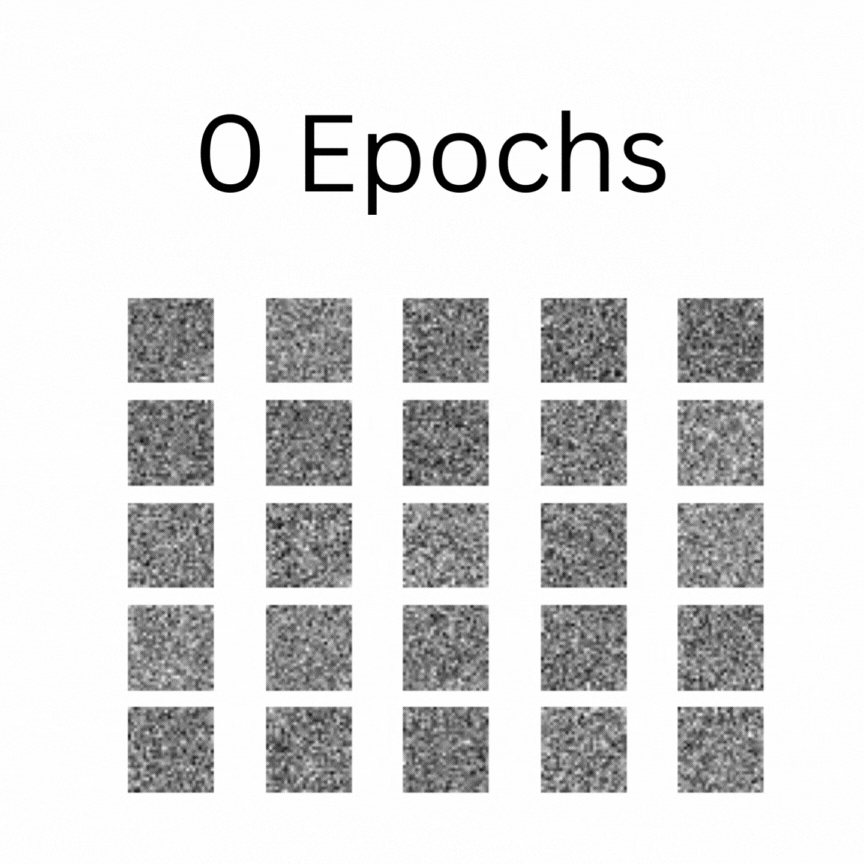

## Vector size is 50 and increase to 10000 epochs with 128 batch size

Significant changes could be noticed in the quality and variety of generated images when the latent dimensions were changed from 100 to 50. Decreasing the latent dimensionality to 50 often caused the outputs to be more bland and also the variation in the outputs to be less since the generator was not able to learn the complexity of the data distribution very well. The synthesized images were also observed to generally be more distorted and lacking in distinguishable attributes. On the other hand, since a latent space size of 100 was kept, the generator managed to produce clearer and more diverse images while maintaining stable training. Therefore, in the case of producing high quality images, a latent space of 100 was better than say a 50.

---



# Question 02

## **Train the GAN for 10,000 epochs. Save and visualize the generated images at every 1000 epochs, then create a GIF or a slideshow to show how the quality of the generated images evolves over time.**

---








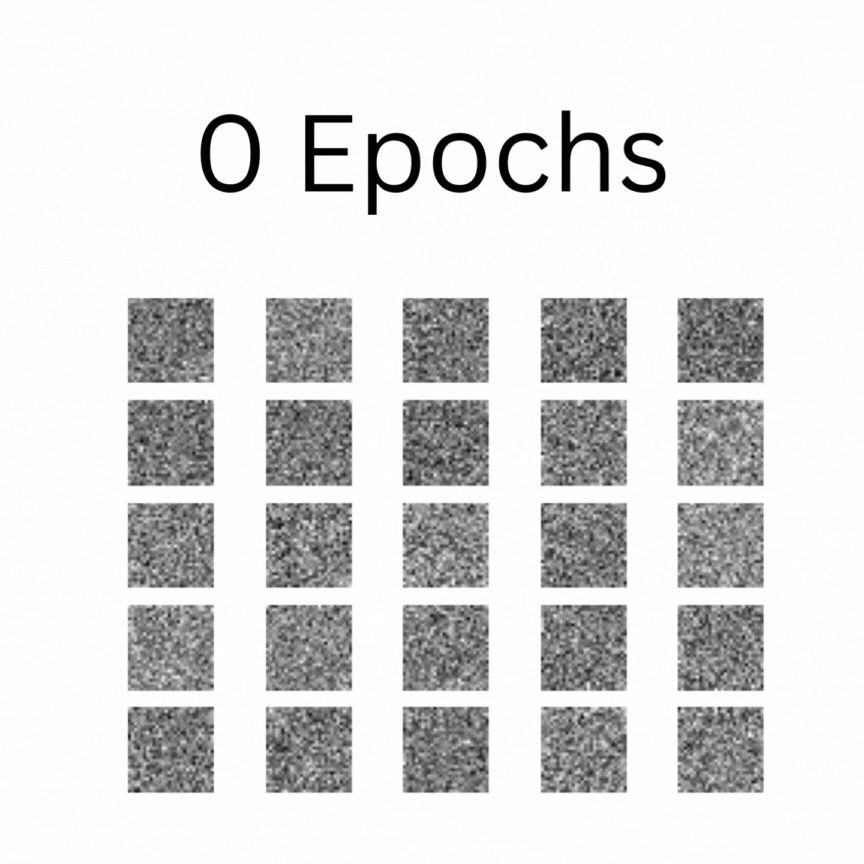

## Vector size is 100 and increase to 10000 epochs with 128 batch size

Following the completion of 10,000 epochs of training of the GAN: It was observed that, discriminator's accuracy had a notable dip, even falling to as low as 0.117% at epoch 3,000. This indicates that the generator may have produced images that the discriminator had difficulties separating. In fact, both the discriminator and generator loss metrics were large and erratic, a standard feature of any GAN training process. Still, there was steady enhancement of the images achieved over a number of epochs as demonstrated in the GIF or slideshow meaning that the generator improved with regard to generating more realistic images with time.



---

# Question 03

## **Change the optimizer from Adam to RMSprop or SGD for both the generator and discriminator, and observe the impact on training performance and image quality.**




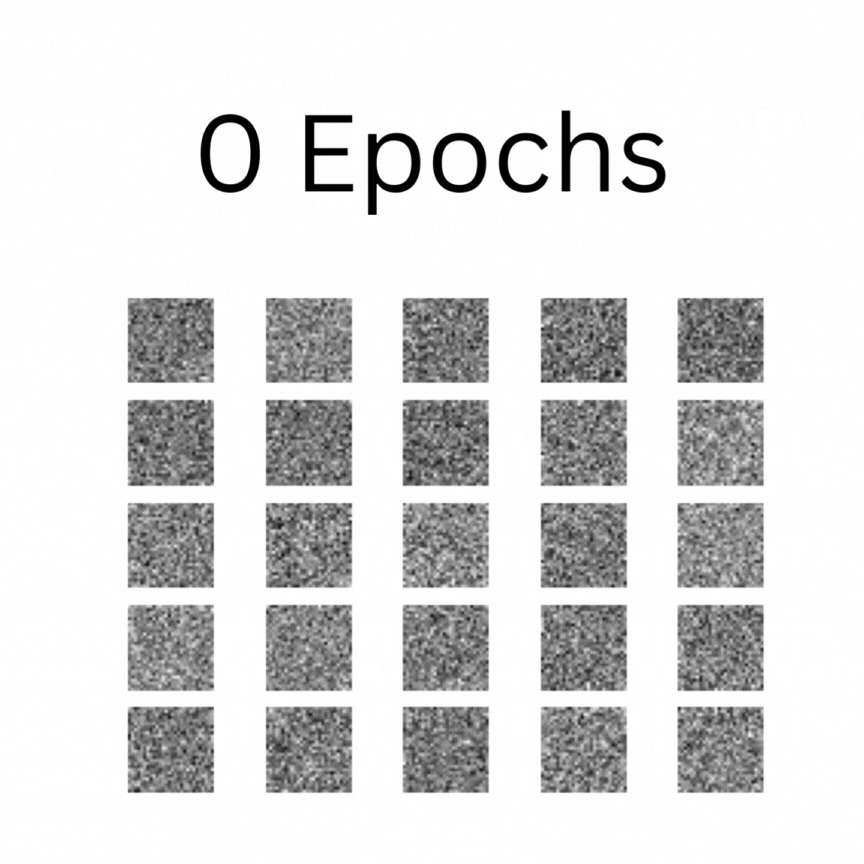

## Change to RMSprop

There is a drastic change in training performance and image quality when the optimizer in the GAN Network is changed from Adam to RMSprop or SGD for both the generator and discriminator. Switching optimizers to RMSprop most of the time facilitates better stability of the training dynamics, helping to restrain the divergence of loss values, which can be helpful in stopping the generator and the discriminator from being too regular. It is, however, at the expense of convergence speed, owing to the fact that it makes one use a larger number of epochs to attain the image quality compared to the use of adam optimizer. Transfer to SGD assumes that I will experience, I may take further to converge because of the unvarying learning rate and absence of a momentum, a feature and this constant rate kills optimal training unless assisted with scheduled rates of work. Therefore, both RMSprop and SGD led to stable training conditions but still needed a lot more precision and longer training times to get images comparable and diverse in quality and characteristics to those produced with the Adams method.

---

# Question 04

## **Experiment with different values of the batch_size. What impact does it have on training?**


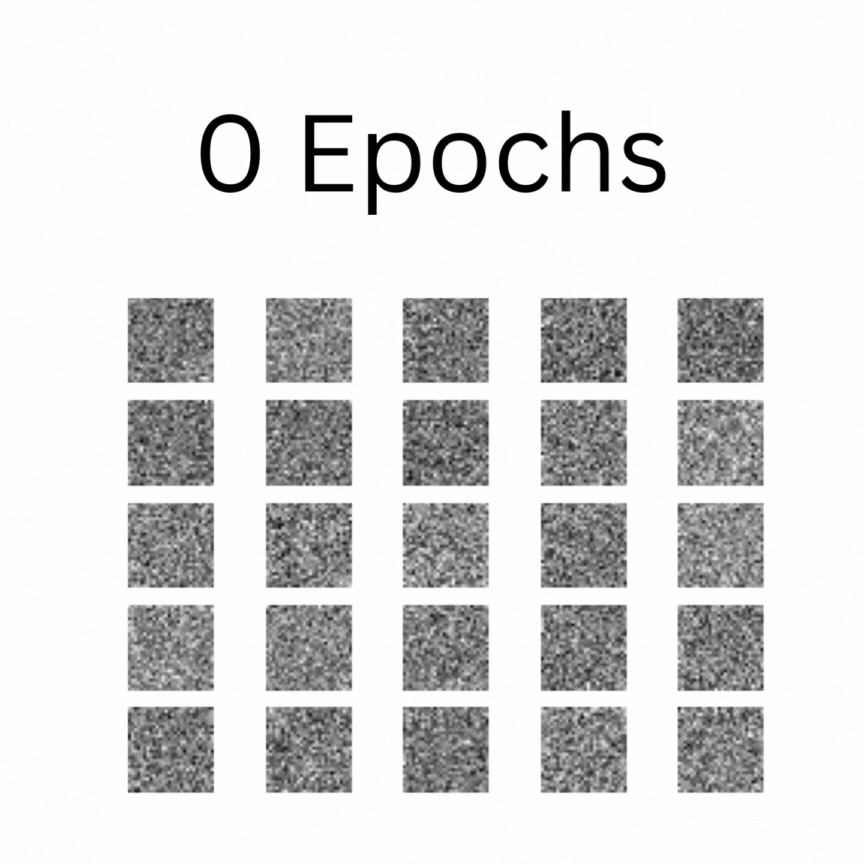

## Change to 64 batch_size

The trials undertaken assessed how varying batch sizes of GANs affected the training performance and stability. At batch sizes of 64 and 50, the results showed that the lower batch size of 50 raised the Discriminator accuracy to 81.64% compared to 52.34% for the higher batch size, which was lower than the sample mean of 50. However, the loss on the generator increased significantly when the smaller batch size was used meaning that the training process became more unstable. These results indicate that smaller batch sizes tend to improve the performance of the Discriminator but are detrimental to the performance of the Generator and hence require optimization of the two models.

---